<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
# TEST on Davis : settings : 1/GIN/5/256~inf

In [2]:
import gc
gc.enable()
gc.collect()

240

In [3]:
import pandas as pd
import  pickle
import matplotlib.pyplot as plt

import scikitplot as skplt
from sklearn.metrics import mean_squared_error
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow_addons as tfa
from keras import backend as K
import tensorflow as tf

from tqdm.keras import TqdmCallback
from tqdm.auto import tqdm
from collections import defaultdict
import pandas as pd
import numpy as np

import mltle as mlt

Done.


In [4]:
# Davis train-test split same as in GraphDTA (Nguyen et al., 2021)
train = pd.read_csv('davis_train.csv')
test = pd.read_csv('davis_test.csv')

In [5]:
from rdkit import Chem

def to_non_isomeric_canonical(s):
    try:
        mol = Chem.MolFromSmiles(s)
        s = Chem.MolToSmiles(mol, isomericSmiles=False, canonical=True)
        return s
    except Exception as e:
        # if smiles is invalid return NaN
        return np.nan

In [6]:
train['compound_iso_smiles'] = train.compound_iso_smiles.map({s:to_non_isomeric_canonical(s) for s in train.compound_iso_smiles.unique()})
test['compound_iso_smiles'] = test.compound_iso_smiles.map({s:to_non_isomeric_canonical(s) for s in test.compound_iso_smiles.unique()})

In [7]:
from rdkit.Chem import QED

In [8]:
def get_mol(s):
    try:
        return Chem.MolFromSmiles(s)
    except:
        return np.nan
def get_qed(s):
    m = get_mol(s)
    try:
        return QED.qed(m)
    except:
        return np.nan

In [9]:
train['qed'] = train.compound_iso_smiles.map({s:get_qed(s) for s in train.compound_iso_smiles.unique()})
test['qed'] = test.compound_iso_smiles.map({s:get_qed(s) for s in test.compound_iso_smiles.unique()})

In [10]:
pH_data = pd.read_csv("human_pH_median.csv").rename(columns={'target':'target_sequence'})
train = pd.merge(train, pH_data, how='left', on ='target_sequence')
test = pd.merge(test, pH_data, how='left', on ='target_sequence')

In [11]:
train = train.sample(frac=1, random_state=7)
valid = train.iloc[-5000:, :]
train = train.iloc[: -5000, :]

In [12]:
train.shape, valid.shape, test.shape

((20046, 5), (5000, 5), (5010, 5))

In [13]:
train.head(5)

,compound_iso_smiles,target_sequence,affinity,qed,pH
11069,COc1cc(Nc2ncc(F)c(Nc3ccc4c(n3)NC(=O)C(C)(C)O4)...,MPALARDGGQLPLLVVFSAMIFGTITNQDLPVIKCVLINHKNNDSS...,9.187087,0.199339,7.5
9732,Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nc(-...,MEAPLRPAADILRRNPQQDYELVQRVGSGTYGDVYKARNVHTGELA...,5.000000,0.362297,NaN
17506,COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1,MLKFKYGARNPLDAGAAEPIASRASRLNLFFQGKPPFMTQQQMSPL...,5.744727,0.541529,NaN
5153,Cc1cc(Nc2cc(N3CCN(C)CC3)nc(Sc3ccc(NC(=O)C4CC4)...,MLPFAPQDEPWDREMEVFSGGGASSGEVNGLKMVDEPMEEGEADSC...,5.000000,0.456816,7.5
15638,COc1cc2c(Oc3ccc4[nH]c(C)cc4c3F)ncnc2cc1OCCCN1C...,MDFDKKGGKGETEEGRRMSKAGGGRSSHGIRSSGTSSGVLMVGPNF...,5.000000,0.371025,NaN


<AxesSubplot:>

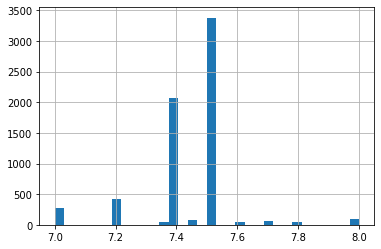

In [14]:
train['pH'].hist(bins=32)

In [15]:
train.notna().sum()

compound_iso_smiles    20046
target_sequence        20046
affinity               20046
qed                    20046
pH                      6499
dtype: int64

In [16]:
SEED = 7

NUM_RES_BLOCKS = 1
GRAPH_DEPTH = 5
GRAPH_FEATURES = 'g78'
GRAPH_TYPE = 'gin_eps0'
NORMALIZE = False
NORMALIZATION_TYPE = ''
NUM_EPOCHS = 1000
DISCOUNT = 0.9
BATCH_SIZE = 512 
data_type = 'pKd'
model_name = f'Res1GIN5_{data_type}_davis'

In [17]:
list(train)

['compound_iso_smiles', 'target_sequence', 'affinity', 'qed', 'pH']

In [18]:
tf.keras.backend.clear_session()
np.random.seed(SEED)
tf.random.set_seed(SEED)

model = mlt.graph_training.GraphModel(protein_emb_size=64, protein_alphabet_len=8006)

order = ['pKd', 'qed', 'pH']
loss_weights = [1.0] * len(order)

variables = {}
for var in order:
    variables[var] = K.variable(0.0)

LossCallback = mlt.training_utils.LossWithMemoryCallback(
    variables, discount=DISCOUNT, decay=0.8)

uselosses = defaultdict(lambda: mlt.training_utils.mse_loss_wrapper)
uselosses['qed'] = 'binary_crossentropy'

for k, v in variables.items():
    if k not in uselosses.keys():
        uselosses[k] = uselosses[k](v)

usemetrics = {data_type: [tf.keras.metrics.mse, mlt.training_utils.cindex_score]}

activations = defaultdict(lambda: 'linear')
activations['qed'] = 'sigmoid'

initializer = tf.keras.initializers.VarianceScaling(scale=1., mode='fan_in', distribution='normal', seed=SEED)
optimizer = tfa.optimizers.Lookahead(tf.keras.optimizers.Nadam(), sync_period=3)

model = model.create_model(order=order,
                           activations=activations,
                           activation='relu',
                           pooling_mode='max',
                           num_res_blocks=NUM_RES_BLOCKS,
                           units_per_head=256, # GraphDTA
                           units_per_layer=1024,
                           dropout_rate=0.3,
                           protein_kernel=(7, 7),
                           loss_weights=loss_weights,
                           usemetrics=usemetrics,
                           uselosses=uselosses,
                           initializer=initializer,
                           optimizer=optimizer,
                           protein_strides_down=1,
                           graph_depth=GRAPH_DEPTH,
                           num_graph_features=78,
                           graph_type=GRAPH_TYPE)

2022-09-18 13:12:54.804078: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-18 13:12:54.804258: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-18 13:12:54.804393: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-18 13:12:54.828088: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-18 13:12:54.828256: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

Done. Total trainable params: 2590053


In [19]:
mapseq = mlt.datamap.MapSeq(drug_mode=GRAPH_FEATURES,
                            protein_mode='protein_3',
                            max_drug_len=100, # max davis=81
                            max_protein_len=float('inf'),
                            graph_normalize=NORMALIZE,
                            graph_normalization_type=NORMALIZATION_TYPE)

drug_seqs = np.hstack((train['compound_iso_smiles'].unique(), valid['compound_iso_smiles'].unique(), test['compound_iso_smiles'].unique()))
protein_seqs = np.hstack((train['target_sequence'].unique(), valid['target_sequence'].unique(), test['target_sequence'].unique()))

map_drug, map_protein = mapseq.create_maps(drug_seqs=drug_seqs,
                                           protein_seqs=protein_seqs)

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/1137 [00:00<?, ?it/s]

In [20]:
batch_size = BATCH_SIZE

train_gen = mlt.datagen.DataGen(train, map_drug, map_protein, drug_graph_mode=True)
train_gen = train_gen.get_generator(batch_size)

valid_gen = mlt.datagen.DataGen(valid, map_drug, map_protein, drug_graph_mode=True, shuffle=False)
valid_gen = valid_gen.get_generator(batch_size)

In [21]:
steps_per_epoch = train.shape[0] // batch_size
valid_steps = valid.shape[0] // batch_size

In [22]:
best_model_path = f"Best_{model_name}.h5"
CheckPointCallback = tf.keras.callbacks.ModelCheckpoint(best_model_path,
                                                        monitor=f'val_{data_type}_mean_squared_error',
                                                        verbose=1,
                                                        save_best_only=True,
                                                        mode='auto',
                                                        save_weights_only=True)

CSVLoggerCallback = tf.keras.callbacks.CSVLogger(f"{model_name}.log")

In [23]:
class TestLikeInGraphDTA(tf.keras.callbacks.Callback):
    """
    In GraphDTA, test folowos valid improvements
    https://github.com/thinng/GraphDTA/blob/master/training_validation.py
    """
    def __init__(self):
        self.best_mse = float('inf')
        self.best_test_mse = float('inf')
        self.best_test_ci = [float('inf')]
    def on_epoch_end(self, epoch, logs=None):
        error = logs[f'val_{data_type}_mean_squared_error']
        if error < self.best_mse:
            self.best_mse = error
            test_batch_size = mlt.training_utils.get_batch_size(test.shape[0])
            test_gen = mlt.datagen.DataGen(test,
                               map_drug,
                               map_protein,
                               shuffle=False,
                               test_only=True, 
                               drug_graph_mode=True)

            test_gen = test_gen.get_generator(test_batch_size)
            prediction = model.predict(test_gen,
                           steps=test.shape[0] // test_batch_size,
                           verbose=1)
            
            col = 'affinity'
            y_true = test[col][test[col].notna()]
            y_pred = prediction[0][test[col].notna()].ravel()
            mse = mean_squared_error(y_true, y_pred)
            ci = concordance_index(y_true, y_pred)

            self.best_test_mse = mse 
            self.best_test_ci  = ci
            print('mse improved at epoch ', epoch, '; best_test_mse, best_test_ci:', mse, ci)

In [24]:
history = model.fit(train_gen,
                    validation_data=valid_gen,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=valid_steps,
                    verbose=0,
                    callbacks=[TqdmCallback(), CheckPointCallback,
                               LossCallback, CSVLoggerCallback, TestLikeInGraphDTA()],
                    epochs=NUM_EPOCHS)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2022-09-18 13:12:57.912402: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-09-18 13:12:58.041558: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-09-18 13:12:58.972745: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-18 13:12:58.973036: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-18 13:12:58.973050: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-09-18 13:12:58.973279: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-18 13:12:58.973319: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to


Epoch 1: val_pKd_mean_squared_error improved from inf to 16.20396, saving model to Best_Res1GIN5_pKd_davis.h5
167/167 [==============================] - 5s 31ms/step
mse improved at epoch  0 ; best_test_mse, best_test_ci: 16.116944509721552 0.3878944006317241

Epoch 2: val_pKd_mean_squared_error improved from 16.20396 to 6.54189, saving model to Best_Res1GIN5_pKd_davis.h5
167/167 [==============================] - 5s 27ms/step
mse improved at epoch  1 ; best_test_mse, best_test_ci: 6.490365802583713 0.4197291709708944

Epoch 3: val_pKd_mean_squared_error improved from 6.54189 to 4.77166, saving model to Best_Res1GIN5_pKd_davis.h5
167/167 [==============================] - 5s 27ms/step
mse improved at epoch  2 ; best_test_mse, best_test_ci: 4.718799449644899 0.44389612390539884

Epoch 4: val_pKd_mean_squared_error improved from 4.77166 to 1.17657, saving model to Best_Res1GIN5_pKd_davis.h5
167/167 [==============================] - 5s 27ms/step
mse improved at epoch  3 ; best_test_mse,


Epoch 53: val_pKd_mean_squared_error did not improve from 0.31397

Epoch 54: val_pKd_mean_squared_error improved from 0.31397 to 0.31194, saving model to Best_Res1GIN5_pKd_davis.h5
167/167 [==============================] - 5s 27ms/step
mse improved at epoch  53 ; best_test_mse, best_test_ci: 0.3242911235825928 0.8680055373873964

Epoch 55: val_pKd_mean_squared_error did not improve from 0.31194

Epoch 56: val_pKd_mean_squared_error improved from 0.31194 to 0.29611, saving model to Best_Res1GIN5_pKd_davis.h5
167/167 [==============================] - 5s 27ms/step
mse improved at epoch  55 ; best_test_mse, best_test_ci: 0.3038244138055622 0.8698945222349322

Epoch 57: val_pKd_mean_squared_error did not improve from 0.29611

Epoch 58: val_pKd_mean_squared_error did not improve from 0.29611

Epoch 59: val_pKd_mean_squared_error did not improve from 0.29611

Epoch 60: val_pKd_mean_squared_error did not improve from 0.29611

Epoch 61: val_pKd_mean_squared_error did not improve from 0.29611


Epoch 139: val_pKd_mean_squared_error did not improve from 0.24694

Epoch 140: val_pKd_mean_squared_error did not improve from 0.24694

Epoch 141: val_pKd_mean_squared_error did not improve from 0.24694

Epoch 142: val_pKd_mean_squared_error did not improve from 0.24694

Epoch 143: val_pKd_mean_squared_error did not improve from 0.24694

Epoch 144: val_pKd_mean_squared_error did not improve from 0.24694

Epoch 145: val_pKd_mean_squared_error did not improve from 0.24694

Epoch 146: val_pKd_mean_squared_error did not improve from 0.24694

Epoch 147: val_pKd_mean_squared_error did not improve from 0.24694

Epoch 148: val_pKd_mean_squared_error did not improve from 0.24694

Epoch 149: val_pKd_mean_squared_error did not improve from 0.24694

Epoch 150: val_pKd_mean_squared_error did not improve from 0.24694

Epoch 151: val_pKd_mean_squared_error did not improve from 0.24694

Epoch 152: val_pKd_mean_squared_error did not improve from 0.24694

Epoch 153: val_pKd_mean_squared_error did not i


Epoch 251: val_pKd_mean_squared_error did not improve from 0.23930

Epoch 252: val_pKd_mean_squared_error did not improve from 0.23930

Epoch 253: val_pKd_mean_squared_error did not improve from 0.23930

Epoch 254: val_pKd_mean_squared_error improved from 0.23930 to 0.23724, saving model to Best_Res1GIN5_pKd_davis.h5
167/167 [==============================] - 5s 27ms/step
mse improved at epoch  253 ; best_test_mse, best_test_ci: 0.25029898323140864 0.8788730200616195

Epoch 255: val_pKd_mean_squared_error did not improve from 0.23724

Epoch 256: val_pKd_mean_squared_error did not improve from 0.23724

Epoch 257: val_pKd_mean_squared_error did not improve from 0.23724

Epoch 258: val_pKd_mean_squared_error did not improve from 0.23724

Epoch 259: val_pKd_mean_squared_error did not improve from 0.23724

Epoch 260: val_pKd_mean_squared_error did not improve from 0.23724

Epoch 261: val_pKd_mean_squared_error improved from 0.23724 to 0.23584, saving model to Best_Res1GIN5_pKd_davis.h5
167


Epoch 363: val_pKd_mean_squared_error did not improve from 0.23447

Epoch 364: val_pKd_mean_squared_error did not improve from 0.23447

Epoch 365: val_pKd_mean_squared_error did not improve from 0.23447

Epoch 366: val_pKd_mean_squared_error did not improve from 0.23447

Epoch 367: val_pKd_mean_squared_error did not improve from 0.23447

Epoch 368: val_pKd_mean_squared_error did not improve from 0.23447

Epoch 369: val_pKd_mean_squared_error did not improve from 0.23447

Epoch 370: val_pKd_mean_squared_error did not improve from 0.23447

Epoch 371: val_pKd_mean_squared_error did not improve from 0.23447

Epoch 372: val_pKd_mean_squared_error did not improve from 0.23447

Epoch 373: val_pKd_mean_squared_error did not improve from 0.23447

Epoch 374: val_pKd_mean_squared_error did not improve from 0.23447

Epoch 375: val_pKd_mean_squared_error did not improve from 0.23447

Epoch 376: val_pKd_mean_squared_error did not improve from 0.23447

Epoch 377: val_pKd_mean_squared_error did not i


Epoch 478: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 479: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 480: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 481: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 482: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 483: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 484: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 485: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 486: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 487: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 488: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 489: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 490: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 491: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 492: val_pKd_mean_squared_error did not i


Epoch 599: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 600: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 601: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 602: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 603: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 604: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 605: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 606: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 607: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 608: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 609: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 610: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 611: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 612: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 613: val_pKd_mean_squared_error did not i


Epoch 720: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 721: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 722: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 723: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 724: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 725: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 726: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 727: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 728: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 729: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 730: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 731: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 732: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 733: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 734: val_pKd_mean_squared_error did not i


Epoch 841: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 842: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 843: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 844: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 845: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 846: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 847: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 848: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 849: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 850: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 851: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 852: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 853: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 854: val_pKd_mean_squared_error did not improve from 0.23072

Epoch 855: val_pKd_mean_squared_error did not i


Epoch 953: val_pKd_mean_squared_error did not improve from 0.22943

Epoch 954: val_pKd_mean_squared_error did not improve from 0.22943

Epoch 955: val_pKd_mean_squared_error did not improve from 0.22943

Epoch 956: val_pKd_mean_squared_error did not improve from 0.22943

Epoch 957: val_pKd_mean_squared_error did not improve from 0.22943

Epoch 958: val_pKd_mean_squared_error did not improve from 0.22943

Epoch 959: val_pKd_mean_squared_error did not improve from 0.22943

Epoch 960: val_pKd_mean_squared_error did not improve from 0.22943

Epoch 961: val_pKd_mean_squared_error did not improve from 0.22943

Epoch 962: val_pKd_mean_squared_error did not improve from 0.22943

Epoch 963: val_pKd_mean_squared_error did not improve from 0.22943

Epoch 964: val_pKd_mean_squared_error did not improve from 0.22943

Epoch 965: val_pKd_mean_squared_error did not improve from 0.22943

Epoch 966: val_pKd_mean_squared_error did not improve from 0.22943

Epoch 967: val_pKd_mean_squared_error did not i

In [26]:
model.load_weights(best_model_path)

In [27]:
test_batch_size = mlt.training_utils.get_batch_size(test.shape[0])
test_batch_size

30

In [28]:
test_gen = mlt.datagen.DataGen(test,
                               map_drug,
                               map_protein,
                               shuffle=False,
                               test_only=True, 
                               drug_graph_mode=True)

test_gen = test_gen.get_generator(test_batch_size)

In [29]:
prediction = model.predict(test_gen,
                           steps=test.shape[0] // test_batch_size,
                           verbose=1)



167/167 [==============================] - 5s 28ms/step


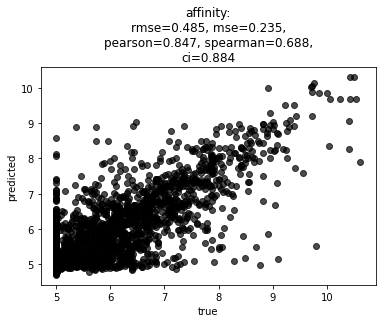

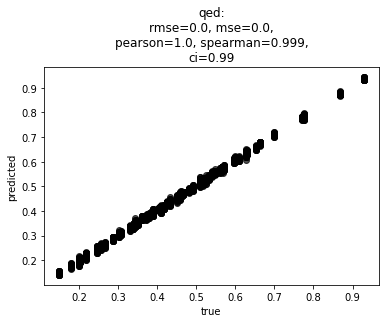

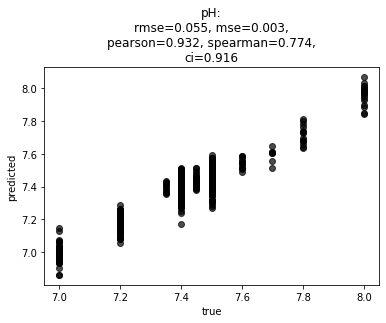

In [30]:
for k, col in enumerate(['affinity', 'qed', 'pH']):
    try:
        plt.scatter(test[col], prediction[k], alpha=0.7, c='k')
        plt.xlabel('true')
        plt.ylabel('predicted')
        y_true = test[col][test[col].notna()]
        y_pred = prediction[k][test[col].notna()].ravel()
        plt.title(col + ":\n" + mlt.training_utils.get_scores(y_true, y_pred))
        plt.show()
    except (ValueError, ZeroDivisionError) as e:
        print(f'Empty set test set for: {col}, values sum = {test[col].sum()}')
        print(f'or zero concordand pairs for the set of length 1, length of values set = {test[col].notna().sum()}')